## 1. Importing Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
from copy import deepcopy
import math

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv


from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from sklearn.metrics import classification_report

from copy import deepcopy

## 2. Read the data as DataFrame

In [2]:
df = pd.read_csv('bank-full.csv')

## 3. EDA

#### a. shape of the data 

In [3]:
df.shape

(45211, 17)

#### b. Datatype of each attribute

In [4]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

Lets try to understand the nature of each column so its easier to convert the datatypes
- numeric: 
    - age: discreate
    - balance: continuos
    - day: discreate
    - duration: discreate
    - campaign: discreate
    - pdays: discreate
    - previous: discreate
- catgorical:
    - job: nominal
    - marital: nominal
    - education: ordinal
    - default: nominal
    - housing: nominal
    - loan: nominal
    - contact: nominal
    - month: ordinal
    - poutcome: ordinal
    - Target: nominal

#### c. Checking the presence of missing values

In [5]:
for col in df.columns:
    if(df[col].dtype == "int64"):
        print(col, ": ", df[col][df[col]==-1].value_counts())

age :  Series([], Name: age, dtype: int64)
balance :  -1    50
Name: balance, dtype: int64
day :  Series([], Name: day, dtype: int64)
duration :  Series([], Name: duration, dtype: int64)
campaign :  Series([], Name: campaign, dtype: int64)
pdays :  -1    36954
Name: pdays, dtype: int64
previous :  Series([], Name: previous, dtype: int64)


it seems the pdays has a missing entries and they are named as -1. here 999 means that the person is not contacted there is no mention of missing values here its common to have missing columns in financial data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There seems to be no missing values at the moment but its better to be cautious and analyse each column seperately for the missing values

#### d. 5 point summary for numerical attributes

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [8]:
df.describe(include='object').T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
Target,45211,2,no,39922


#### e. checking for presence of outliers

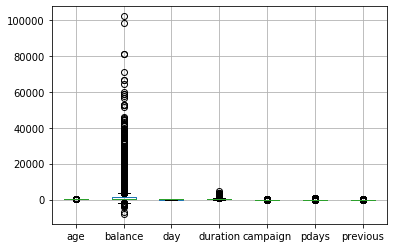

In [9]:
df.boxplot()
plt.show()

its sometimes okay to contain outliers in the data because these are the edge cases which will help us explore deep patterns
here balance is important to have outliers cause the major distribution of the values align with defaulters.
rest of the values. balance can be handled by rescaling the data during the training.
as for the rest of the columns the same can be applied.

other outliers can be handled by using zscores

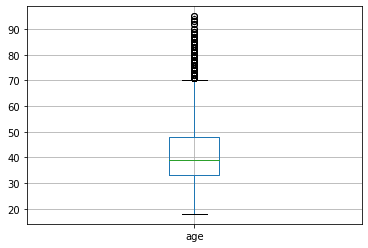

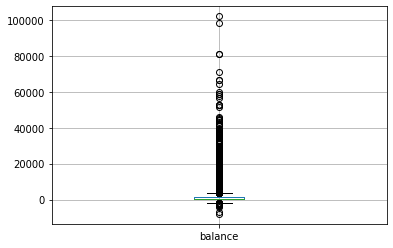

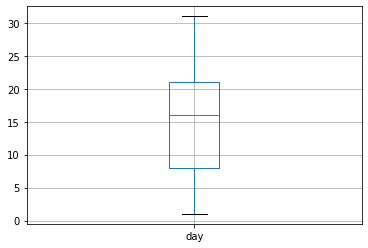

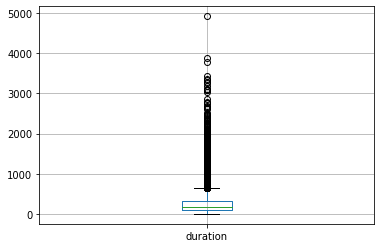

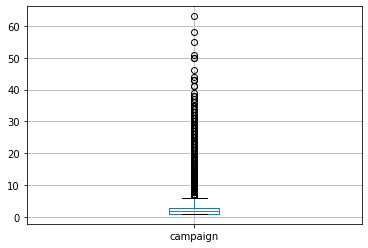

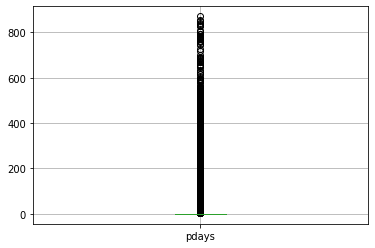

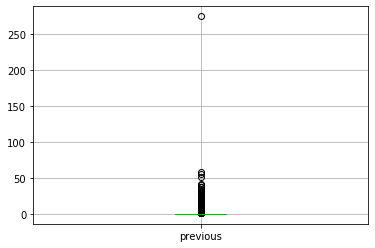

In [87]:
for column in df:
    if(df[column].dtype == "int64"):
        plt.figure()
        df.boxplot([column])

it seems age, balance, duration, campaign, pdays and previous have outliers

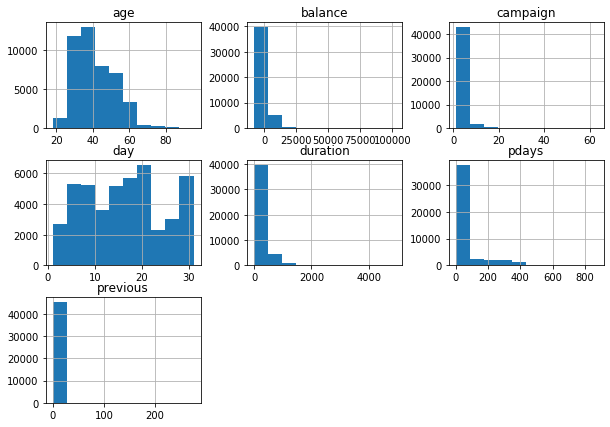

In [10]:
df.hist(figsize=(10, 7))
plt.show()

by looking at the plots none of the variables are normal in nature so using median as a imputation will suffice.
seems balance, campaign, duration and pdays are following poisson distribution

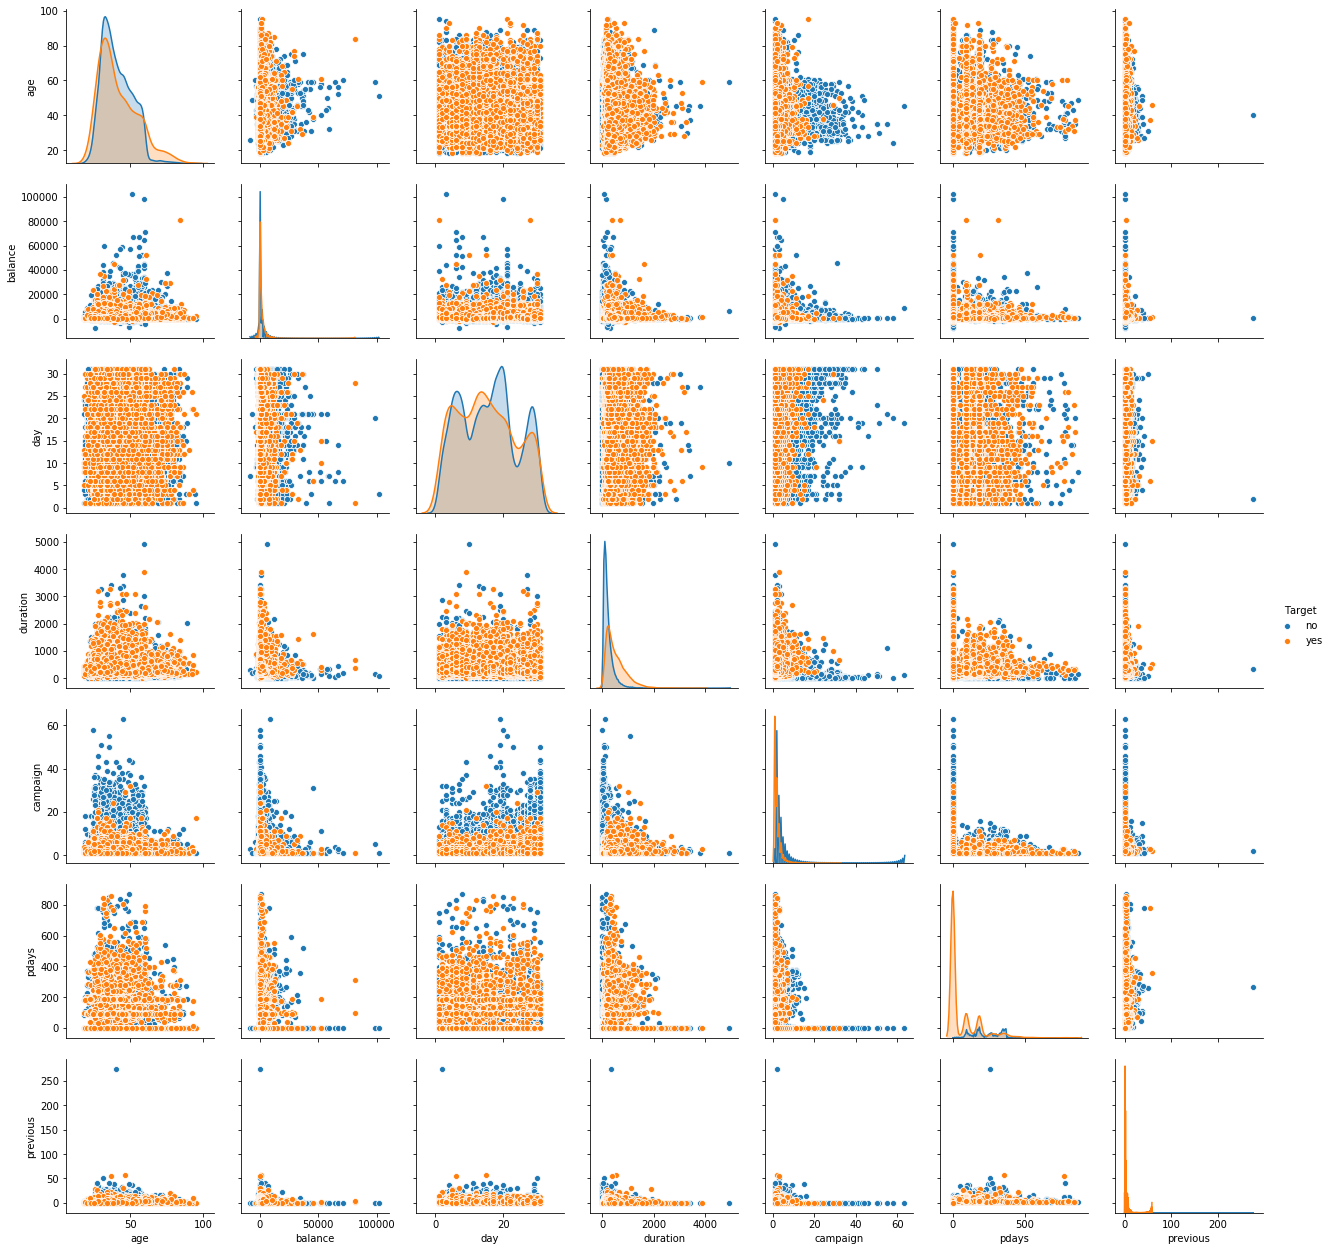

In [79]:
sns.pairplot(df, diag_kind='kde', hue="Target")
plt.show()

the data has a lot of custers and a clustering algo would perform better at identifying the target

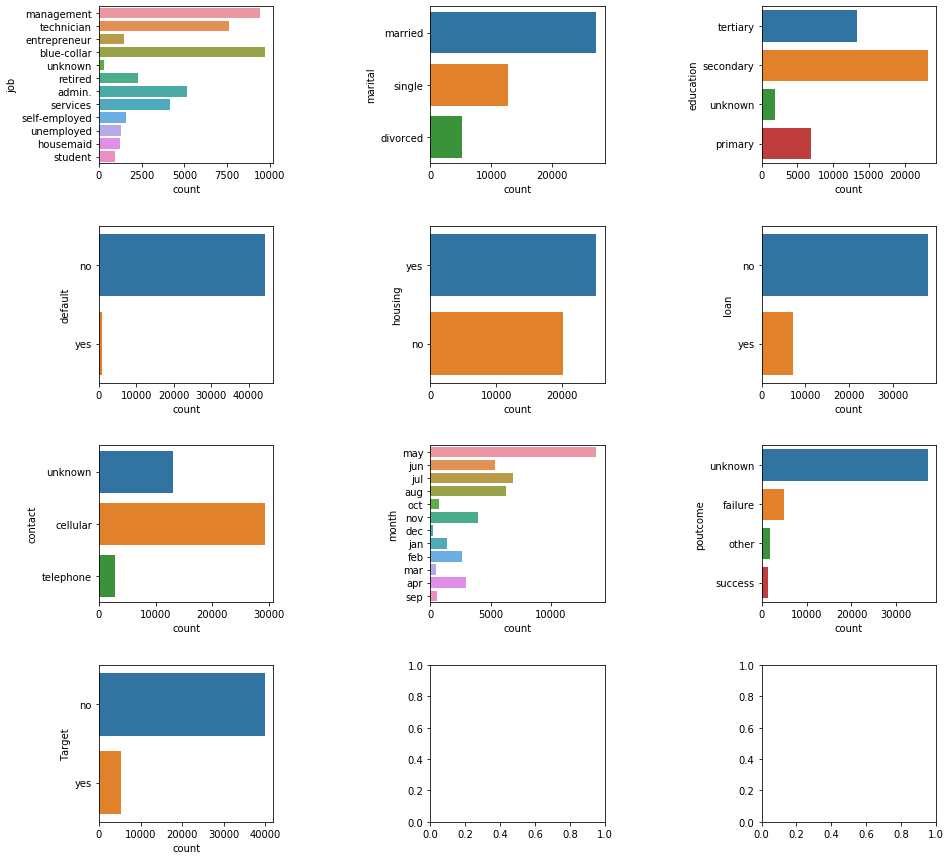

In [13]:
cat_cols = [
    "job",
    "marital",
    "default",
    "housing",
    "loan",
    "contact",
    "poutcome"
    "education",
    "month",
    "Target"
]

fig, axs = plt.subplots(4,3, figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.9)
cat_cols = df.select_dtypes(exclude=['int64']).columns
for i in range(len(cat_cols)):
    sns.countplot(y = cat_cols[i], data=df, orient="v", ax=axs[int(i/3), i%3])
plt.show()

Seems like major campaigns happen through telemarketing.
very less people were sanctioned a loan
the target is severly undersampled might have to use smote in the analysis.

## 4. Data Preparation 

In [14]:
def categorical_encoder(df, target, nominal=[], ordinal=[]):
    """
    Encodes the columns of choice based on the nature of the column 
    and retaines the string indices of the targets
    
    Args:
        df (DataFrame): DataFrame with Categorical Columns
        target (str): Choice of column to be used as target. this should be categorical in nature.
        nominal (list(str)): list of column names which are nominal(order is not important) in nature. 
                             these columns are encoded using one hot label encoding scheme.
        ordinal (list(str)): list of column names which are ordinal(order is important) in nature. 
                             these columns are encoded using normal label encoding.
                             
    return:
        df1: DataFrame with encoded columns
        codes: list of labels in the target and feature colums in the order they are encoded.
    """
    codes = {}
    
    df1 = deepcopy(df)
    
    for col, cats in ordinal.items():
        if( not cats):
            df1[col] = pd.Categorical(df1[col])
        else:
            df1[col] = pd.Categorical(df1[col], categories=cats, ordered=True)
        
        codes[col] = df1[col].cat.categories
        df1[col] = df1[col].cat.codes # encodes the column values using label encoding
        
    for col in nominal:
        df1[col] = pd.Categorical(df1[col])
        codes[col] = df1[col].cat.categories
        df1 = pd.concat([df1, pd.get_dummies(df1[col], prefix=col)], axis=1) # encodes using One Hot Label encoding
        df1.drop([col], axis=1, inplace=True)
      
    df1[target] = pd.Categorical(df1[target])
    codes[target] = df1[target].cat.categories
    df1[target] = df1[target].cat.codes # encoding target using label encoding 
    
    return df1, codes

here we are generating 2 datasets one is with One Hot Label Encoding and Label Encoding and other is with Label Encoding

In [15]:
nominal = [
    "job",
    "marital",
    "default",
    "housing",
    "loan",
    "contact",
    "poutcome"
]

ordinal = {

"education":['primary', 'secondary', 'tertiary', 'unknown'],
"month": ['jan',  'feb', 'mar', 
         'apr', 'may', 'jun',
         'jul', 'aug', 'sep',
         'oct', 'nov', 'dec']
}

df_enc1, enc_codes1 = categorical_encoder(df, "Target", nominal, ordinal)

nominal = [
]

ordinal = {
"job":[],
"marital":[],
"default":[],
"housing":[],
"loan":[],
"contact":[],
"poutcome":[],
"education":['primary', 'secondary', 'tertiary', 'unknown'],
"month": ['jan',  'feb', 'mar', 
         'apr', 'may', 'jun',
         'jul', 'aug', 'sep',
         'oct', 'nov', 'dec']
}

df_enc2, enc_codes2 = categorical_encoder(df, "Target", nominal, ordinal)

In [16]:
target = "Target"
X = {} 
y = {}
X['OHE + Label'] = df_enc1.drop(target, axis=1)
y['OHE + Label'] = df_enc1[[target]].values
X['Label'] = df_enc2.drop(target, axis=1)
y['Label'] = df_enc2[[target]].values

#### Data Sampling using smote
the data is severly unbalanced to we used SMOTE technique to handle the imbalances present in the data

In [17]:
X_sm, y_sm = {}, {}

for key, _ in X.items():
    smote = SMOTE(ratio='minority')
    X_sm[key], y_sm[key] = smote.fit_sample(X[key], y[key])
    X_sm[key] = pd.DataFrame(X_sm[key])
    X_sm[key].columns = X[key].columns

here we are scaling the data using MinMaxScaler and applying a transform on the Label Encoded dataset so we can use it for the CatBoost model

In [18]:
X_scaled, y_scaled = {}, {}

key = "OHE + Label"
X_scaled[key] = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(X_sm[key]))
X_scaled[key].columns = X[key].columns
y_scaled[key] = y_sm[key]


key = "Label"

def transform_to_original(X, enc_codes, target):
    for key, val in enc_codes.items():
        if(key != target):
            dict_mappings = { i : val[i] for i in range(0, len(val) ) }
            X[key] = X[key].map(dict_mappings)
            X[key] = X[key].astype(np.object)
            
    for col in X.columns:
        if(X[col].dtype == "int64"):
            X[col] = X[col].astype(np.float64)
    return X

X_scaled[key] = transform_to_original(X_sm[key], enc_codes2, "Target")
X_scaled[key].columns = X[key].columns
y_scaled[key] = y_sm[key]

Preparing the train and test datasets for the experiments

In [19]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}

for key, _ in X.items():
    X_train[key], X_test[key], \
    y_train[key], y_test[key] = \
        train_test_split(
            X_scaled[key], y_scaled[key], 
            test_size=0.3,
            shuffle=True,
            random_state=42)

## 5. Model Training and Improvement
we are going to use the following models:

- logistic regression
- naived bayes
- k-nn
- svc
- Decision Tree
- Random Forest
- Bagging Classifier
- CatBoost
- LightGBM
- XGBoost

as this is a classification problem

we are going to use hyperopt for tuning the parameters and cross validation to ensure the quality of the models.
we will compare each experiment on the training data to asure the quality of the model
we are going to use an open source tool called hyperopt which is going to speed up the process of finding the best parameters for each model without wasting much time experimenting all the combinations. this will give us more time to study and improve our features.

reasons hyperopt was choosen is it uses baysian optimisation using TPE algo which will suggest most likely params for each model. the exploration is faster than grid search and random search used in sklearn



setting up some environment variables for logging the experiment results

In [20]:
experiments = {}
target = "median"
experiment = {}
best = {}
trials = {}

#### Logistic Regression

this model has made a good accuracy on the training test and the time to train is decent enough on a cpu bound training method

In [21]:
def logistic_regression(params):
    model = LogisticRegression(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores = np.array(cross_val_score(model, X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    mean = np.mean(scores)
    std = np.std(scores)
    return {
        'loss': - mean,
        'status': STATUS_OK,
        'loss_error': std,
        'model': trained_model
    }

params = {
  'C' : hp.uniform('C', 0, 1),
  'penalty': hp.choice('penalty', ['l1', 'l2'])
}
trials['logistic_regression'] = Trials()
best['logistic_regression'] = fmin(logistic_regression, params, algo=tpe.suggest, trials=trials['logistic_regression'], max_evals=10)

100%|██████████| 10/10 [12:48<00:00, 76.89s/it, best loss: -0.9360171313359311]


#### Naive Bayes

fast training time but not a good estimator on the training score

In [22]:
def naive_bayes(params):
    model = MultinomialNB(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    mean = np.mean(scores)
    std = np.std(scores)
    return {
        'loss': - mean,
        'status': STATUS_OK,
        'loss_error': std,
        'model': trained_model
    }

params = {
        'alpha': hp.uniform('alpha', 0, 1)
    }
trials['naive_bayes'] = Trials()
best['naive_bayes'] = fmin(naive_bayes, params, algo=tpe.suggest, trials=trials['naive_bayes'], max_evals=10)

100%|██████████| 10/10 [00:03<00:00,  3.19it/s, best loss: -0.8305599858984509]


#### K Nearest Neighbors

Took a long time to train but its not so better than logistic regression

In [23]:
def knn(params):
    model = KNeighborsClassifier(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    mean = np.mean(scores)
    std = np.std(scores)
    return {
        'loss': - mean,
        'status': STATUS_OK,
        'loss_error': std,
        'model': trained_model
    }

params = {
        'n_neighbors': ho_scope.int(hp.quniform('n_neighbors', 1, 10, 1))
}

ho_sample(params)
trials['knn'] = Trials()
best['knn'] = fmin(knn, params, algo=tpe.suggest, trials=trials['knn'], max_evals=10)

100%|██████████| 10/10 [18:56<00:00, 113.64s/it, best loss: -0.9310609514100937]


#### Support Vector Machines

Took a really large time to train prefereable to use PCA the next time using this model the score is not so good when compared to logistic regression

In [37]:
def svc(params):
    model = SVC(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    mean = np.mean(scores)
    std = np.std(scores)
    return {
        'loss': - mean,
        'status': STATUS_OK,
        'loss_error': std,
        'model': trained_model
    }

params = {
    'C': hp.lognormal('C', 0, 1),
    'kernel': hp.choice('kernel', ['rbf']),
}

trials['svc'] = Trials()
best['svc'] = fmin(svc, params, algo=tpe.suggest, trials=trials['svc'], max_evals=5)

100%|██████████| 5/5 [58:26<00:00, 701.37s/it, best loss: -0.9317229180599528]


#### Decision Tree classifier

here we are using a loss metric called deference between the training and testing accuracy scores so we can have a more reliable model in testing environment

In [29]:
def decision_tree(params):
    model = DecisionTreeClassifier(**params)
    trained_model= model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores1 = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    scores2 = np.array(cross_val_score(model,  X_test["OHE + Label"], y_test["OHE + Label"], cv=10))
    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    loss = mean1 - mean2
    return {
        'loss': loss,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'criterion': 'entropy',
        'max_depth': ho_scope.int(hp.quniform('max_depth', 1, 10, 1)),
        'min_samples_leaf': ho_scope.int(hp.quniform('min_samples_leaf', 1, 10, 1))
}

trials['decision_tree'] = Trials()
best['decision_tree'] = fmin(decision_tree, params, algo=tpe.suggest, trials=trials['decision_tree'], max_evals=10)

100%|██████████| 10/10 [00:33<00:00,  3.34s/it, best loss: 0.008229079467119815]


#### Bagging Classifier

In [30]:
def bagging(params):
    model = BaggingClassifier(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores1 = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    scores2 = np.array(cross_val_score(model,  X_test["OHE + Label"], y_test["OHE + Label"], cv=10))
    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    loss = mean1 - mean2
    return {
        'loss': loss,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'n_estimators': ho_scope.int(hp.quniform('n_estimators', 1, 50, 1)),
        'max_samples': hp.uniform('max_samples', 0,1),
        'oob_score': hp.choice('oob_score', [True, False])
}

ho_sample(params)
trials['bagging'] = Trials()
best['bagging'] = fmin(bagging, params, algo=tpe.suggest, trials=trials['bagging'], max_evals=10)

100%|██████████| 10/10 [08:03<00:00, 48.39s/it, best loss: 0.009890730126214109]


#### Random Forest Classifier

In [31]:
def random_forest(params):
    model = RandomForestClassifier(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores1 = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    scores2 = np.array(cross_val_score(model,  X_test["OHE + Label"], y_test["OHE + Label"], cv=10))
    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    loss = mean1 - mean2
    return {
        'loss': loss,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'n_estimators': ho_scope.int(hp.quniform('n_estimators', 1, 10, 1))
}

trials['random_forest'] = Trials()
best['random_forest'] = fmin(random_forest, params, algo=tpe.suggest, trials=trials['random_forest'], max_evals=10)

100%|██████████| 10/10 [00:41<00:00,  4.18s/it, best loss: 0.008685983592731317]


#### CatBoost

In [36]:
categorical_var = np.where(X_train["Label"].dtypes != np.float64)[0]
def catboost(params):
    model = CatBoostClassifier(**params)
    train_data = Pool(X_train["Label"], y_train["Label"], cat_features=categorical_var)
    test_data = Pool(X_test["Label"], y_test["Label"], cat_features=categorical_var)
    trained_model = model.fit(train_data, plot=False, silent=True)
    cv_params = {"iterations": 40,
          "depth": 2,
          "loss_function": "Logloss",
          "verbose": False}
    scores1 = np.array(cv(train_data,
                        cv_params,
                        fold_count=10, 
                        plot="False")
                      )
    mean1 = np.mean(scores1)
    return {
        'loss': -mean1,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'iterations': ho_scope.int(hp.quniform('iterations', 1, 50, 1))
}

trials['catboost'] = Trials()
best['catboost'] = fmin(catboost, params, algo=tpe.suggest, trials=trials['catboost'], max_evals=1)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

100%|██████████| 1/1 [02:22<00:00, 142.71s/it, best loss: -4.1174004403743965]


#### LightGBM

In [33]:
def lightgbm(params):
    model = LGBMClassifier(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores1 = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    scores2 = np.array(cross_val_score(model,  X_test["OHE + Label"], y_test["OHE + Label"], cv=10))
    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    loss = mean1 - mean2
    return {
        'loss': loss,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'n_estimators': ho_scope.int(hp.quniform('n_estimators', 1, 10, 1))
}

trials['lightgbm'] = Trials()
best['lightgbm'] = fmin(lightgbm, params, algo=tpe.suggest, trials=trials['lightgbm'], max_evals=10)


100%|██████████| 10/10 [00:23<00:00,  2.35s/it, best loss: 0.008690533788003885]


#### XGBoost

In [35]:
def xgboost(params):
    model = XGBClassifier(**params)
    trained_model = model.fit(X_train["OHE + Label"], y_train["OHE + Label"])
    scores1 = np.array(cross_val_score(model,  X_train["OHE + Label"], y_train["OHE + Label"], cv=10))
    scores2 = np.array(cross_val_score(model,  X_test["OHE + Label"], y_test["OHE + Label"], cv=10))
    mean1 = np.mean(scores1)
    mean2 = np.mean(scores2)
    loss = mean1 - mean2
    return {
        'loss': loss,
        'status': STATUS_OK,
        'model': trained_model
    }

params = {
        'n_estimators': ho_scope.int(hp.quniform('n_estimators', 1, 10, 1))
}

trials['xgboost'] = Trials()
best['xgboost'] = fmin(xgboost, params, algo=tpe.suggest, trials=trials['xgboost'], max_evals=10)

100%|██████████| 10/10 [00:53<00:00,  5.33s/it, best loss: 0.0027772136138255465]


In [39]:
experiment["best"] = best
experiment["trials"] = trials
experiments[target] = experiment

## 6. Model Interpretation and insights
we are going to generate some scoreboards to help us easily detect the performace of each model

In [41]:
def clf_report_gen(set_name, imputation, rebalance, scaler, trials, X, y):
    clf_reports = {}
    for key in trials.keys():
        if(key == "catboost"):
            clf_reports[key] = pd.DataFrame(
                classification_report(
                    y["Label"],
                    trials[key].best_trial['result']['model'].predict(X["Label"]),
                    target_names=list(enc_codes1['Target']) ,
                    output_dict=True)
            )
        else:
            clf_reports[key] = pd.DataFrame(
                classification_report(
                    y["OHE + Label"],
                    trials[key].best_trial['result']['model'].predict(X["OHE + Label"]),
                    target_names=list(enc_codes1['Target']) ,
                    output_dict=True)
            )
        
    final_report = pd.DataFrame()
    
    for keys, report in clf_reports.items():
        clf_report = pd.DataFrame()
        report.index.name = "metric"
        for metric in report.index:
            temp = report[report.index == metric]
            temp.columns = [metric + "_" + col for col in temp.columns]
            temp.reset_index(inplace=True, drop=True)
            temp.dropna(inplace=True)
            clf_report = pd.concat([clf_report, temp], axis=1)
        clf_report["model"] = keys
        final_report = pd.concat([final_report, clf_report], axis=0)
    final_report["set_name"] = set_name
    final_report["imputation"] = imputation
    final_report["class rebalance"] = rebalance
    final_report["transformation"] = scaler
    final_report = final_report.set_index([ "class rebalance", "transformation", "imputation", "set_name", "model"])
    
    return final_report

scores = pd.DataFrame()
for key in experiments.keys():
    final_report_train = clf_report_gen("train", key, "smote", "MinMaxScaler", experiments[key]["trials"], X_train, y_train)
    final_report_test = clf_report_gen("test", key, "smote", "MinMaxScaler",  experiments[key]["trials"], X_test, y_test)
    report = pd.concat([final_report_train.T, final_report_test.T], axis=1)
    scores = pd.concat([scores, report.T], axis=0)

In [42]:
scores

f1-score_no  \
class rebalance transformation imputation set_name model                              
smote           MinMaxScaler   median     train    logistic_regression     0.938179   
                                                   naive_bayes             0.828802   
                                                   knn                     0.944587   
                                                   svc                     0.935272   
                                                   decision_tree           0.857190   
                                                   random_forest           0.997231   
                                                   bagging                 0.980559   
                                                   catboost                0.912693   
                                                   lightgbm                0.914783   
                                                   xgboost                 0.841315   
                                          test     logistic_regression     0.937714   
                                                   naive_bayes             0.825477   
                                                   knn                     0.933205   
                                                   svc                     0.933944   
                                                   decision_tree           0.852228   
                                                   random_forest           0.939162   
                                                   bagging                 0.938660   
                                                   catboost                0.903258   
                                                   lightgbm                0.910387   
                                                   xgboost                 0.837589   

                                                                        f1-score_yes  \
class rebalance transformation imputation set_name model                               
smote           MinMaxScaler   median     train    logistic_regression      0.933660   
                                                   naive_bayes              0.833121   
                                                   knn                      0.939733   
                                                   svc                      0.927763   
                                                   decision_tree            0.863682   
                                                   random_forest            0.997223   
                                                   bagging                  0.980327   
                                                   catboost                 0.914590   
                                                   lightgbm                 0.913586   
                                                   xgboost                  0.850587   
                                          test     logistic_regression      0.932946   
                                                   naive_bayes              0.829482   
                                                   knn                      0.927093   
                                                   svc                      0.926005   
                                                   decision_tree            0.858578   
                                                   random_forest            0.938008   
                                                   bagging                  0.937763   
                                                   catboost                 0.905352   
                                                   lightgbm                 0.909007   
                                                   xgboost                  0.846157   

                                                                        f1-score_accuracy  \
class rebalance transformation imputation set_name model                                    
smote           MinMaxScaler   med

- here we can see knn is performing better than naive_bayes and logistic regression due to its non-parametric approach of analysing the data points
- knn has a huge variation in the training set and testing set and its true as its a lazy learner and this algo is distance based so any outliers in the data might have made the model slightly bad
- the model parameters are checked using a 10- fold cross validation and maximized on the accuracy metric
- svc has more reliable accuracy of 93% on both training and testing sets but is computationally expensive to compute.
- decision tree also has a consistent performance but a low accuracy
- random forest performed really well but there is a divergence in the train and test set accuracy. same for the bagging models
- Catboost, lightgbm and XGBoost have a more consistent performance so tuning the parameters on more trials can improve the performance further. this is true as the model tries to relearn the mistakes with a weightage.


In [56]:
model_params = {}
for model, trials in experiments["median"]["trials"].items():
    params = experiments["median"]["trials"][model].best_trial["misc"]["vals"]
    model_params[model] = params
pd.DataFrame(model_params).fillna('')

,logistic_regression,naive_bayes,knn,svc,decision_tree,random_forest,bagging,catboost,lightgbm,xgboost
C,[0.2694956459003609],,,[4.6042180522795295],,,,,,
alpha,,[0.09816312395107252],,,,,,,,
iterations,,,,,,,,[45.0],,
kernel,,,,[0],,,,,,
max_depth,,,,,[5.0],,,,,
max_samples,,,,,,,[0.3731480113584934],,,
min_samples_leaf,,,,,[7.0],,,,,
n_estimators,,,,,,[9.0],[30.0],,[9.0],[6.0]
n_neighbors,,,[6.0],,,,,,,
oob_score,,,,,,,[0],,,


the above are all the parameters learned by the models using hyperopt tool running experiments on a training server would help us run more trials and explore the parameter space more efficiently

## Furthur Improvements
- using feature extraction and feature elimination techniques can really improve the scores
- there are many parameters in the ensemble models which can be tuned to squeeze more performance and as we know the base parameters using the search we can baby sit these models to improve the performance further.
- the polynomial features can add more to the accuracy.
- we have used mice, smote and MinMaxScaler to present a generic classification score board which can be used to make the training much simpler and easier to evaluate the models. further making a library out of this can help aid classification tasks down the line so the focus can be shifted to selecting better features.
- using LIME and SHAPE we could visualise which features were contributing to model performances.